# Project 2: Uncles and Uncles Rewards
- Model a Blockchain that uses uncles and uncle rewards
- Model rewarding mechanism to reward uncle block creators
- Model selfish mining (only one attacker) in this blockchain

Try to answer the following questions with your experiment:
1. How do uncles improve the fairness of the blockchain? For this, you should compare the outcome of miners with and without uncles.
2. What is the impact of uncles on selfish mining? Is selfish mining more profitable with uncles?
3. What does it mean in this model for the selfish mining attack to be profitable?

 Since more miners will get rewards for mining, even if they don't finish a block that is part of the longest chain, they will be rewarded for it. So the time and energy used for that block will not be as wasted, and it seems more rewarding to mine. Show net money with and without uncle rewards to display point. The concept of it is for fairness, but may encourage selfish mining. 

## Introduction

Blockchains are currently a hot topic of research, and they have their fair share of problems. In this project, we will explore the concepts of uncles and uncles rewards in blockchains. Uncles is a measure that can be implemented in a blockchain to improve fairness, and it functions by giving some money to miners who lose their mined blocks in a fork while also giving some incentive to the other miners to include this reward in their own blocks. This project assumes knowledge of the implementation of proof-of-work and a full blockchain.

### Uncles and uncles reward

An uncle is essentailly a block that was discarded because it ended up in a fork that didn't grow to be the longest chain. It is called uncle because it is a block that builds on another block, it's parent, which is also the parent of another block, it's sibling, that ended up in the longest chain, and therefore has a child block that can be regarded as the nephew of that first block. This means it only becomes an uncle block when it has a uncle/nephew relationship with a block in the longest chain. The idea is that the miner who mined the uncle block should also get some reward for the effort they spent to mine that block, and this should in theory increase the fairness of the blockchain.

![Uncle and nephew blocks](Figures/UncleBlock.png?raw=true "Uncle and nephew blocks")

In order to make miners include a uncle reward in the blocks they mine, it is also important that the nephew also gets some reward. So in total, two new rewards/transactions are added, the nephew reward and the uncle reward, in order to help aleviate the loss incured when mining a block that ends up in a discarded fork.

There are multiple different implementations possible for this kind of reward system, with differences like:

- How many uncles can a single nephew give rewards to?
- How far apart in the chain can two blocks be while still being considered uncle/nephew?
- If an uncle reward can be given to a block that's further apart than a direct uncle, should the reward be the same? If not, how much should it decrease by?
- How much is the uncle reward?
- How much is the nephew reward?
- Can an uncle reward be given to child blocks of an uncle, or just the uncle?

And all of these parameters may affect the fairness. In addition to that, they may have unintended consequenses, like encouraging mining on a fork that isn't the longest, if implemented wrong.

#### Fairness
It is important to define fairness before we continue: the fairness for an individual miner is defined as the portion of the reward given to them compared to the portion of mining power they have. Which is the same as their ratio of reward to power, compared to the total ratio of the same.
 
$Fairness(miner) = \frac{\text{miner reward}}{\text{total reward}} / \frac{\text{miner power}}{\text{total power}} = \frac{\text{miner reward} }{\text{miner power}} / \frac{\text{total reward}}{\text{total power}}$

Using this measure, the closer the value is to 1, the more fair the chain is for that particular miner. It is important to note that this measure is defined on the interval $\left[0, \frac{\text{total power}}{\text{miner power}}\right].$ The fairness changes equally when increasing or decreasing the reward, in absolute terms, not relative. That means that when increasing the reward by some amount $\text{k}$ coins, it changes the fairness the same amount as if the reward had been decreased by $\text{k}$ coins. This is in contrast to a relative fairness measure where increasing the reward by a factor of $\text{x}$ would have the same amount of dividing the reward by $\text{x}.$ This means that 

<!--TODO rewrite-->
To figure out how fair the chain as a whole is, we could take the average of the fairness for each miner, but this would be a rather bad measure, since the increased portion of reward for one miner would always result in less for the others, making the average always hover around 1, even when one miner is hoggin a much larger portion than it should. Instead, a cumulative measure of the absolute distance from totally fair, $Fairness = 1$, for each miner would be more useful, however this would be a measure of unfairness, not fariness. Defining the fairness as $\frac{1}{\text{unfairness}}$ would result in a value that is hard to manage between 0 and infinity, virtually useless, so instead we are simply going to use $-\frac{\text{unfairness}}{\text{number of miners}}$ as the measure for fairness, even though this value is then between 0 and -infinity.



<!-- $Fariness = \frac{P(t|f) P(f)}{P(t)} = \frac{P(t|f) P(f)}{\sum_{f' \in \mathcal{F}} P(t|f')P(f')},$ -->

### Imports

In [2]:
#Import statements
from draw_blockchain import show
import hashlib as hasher
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from dataclasses import dataclass
import functools
import operator
import pandas as pd
from scipy import stats

### Hash function
Copy of the hashing functions used in the lecture 5 notebook. This could have been abstracted to random numbers of some kind, since we are not interesed in the hasing. The mining power is just defined as how many _tries_ each round the miners get at solving the pow. However we did not focus on this, and therefore it is just as in the lectures.

In [3]:
def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def hash(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    #print(type(inputbytes))
    hash_obj.update(inputbytes)
    return hash_obj.hexdigest()

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

### Block
Same as in the lecture notebook

In [4]:
class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0, blockchain=None):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0", blockchain, genesis=True)
            self.height = 0
            self.color = "#AEF751"
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
            self.color = creator.color
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data + self.creator.name + self.previous_hash + str(self.nonce))

    def print(self):
        print(self.data + " "+ self.creator.name + " " + str(self.height))

### Blockchain

In [5]:
class Blockchain:
    def __init__(self, genesis_data, difficulty, blockReward=10, static=False):
        self.chain = []
        self.difficulty = difficulty
        self.size = 0
        self.block_reward = blockReward
        self.uncles = []
        self.static = static
        self.chain.append(Block(genesis_data, blockchain=self))

    def longestChain(self, static=-1):
      max = self.chain[0].height
      for block in self.chain:
          if block.height > max:
                max = block.height
      maxes = [block for block in self.chain if block.height == max]
      static %= len(maxes)
      r = maxes[static:static+1] if static >= 0 else random.choices(maxes, k=1)
      return r[0]
    
    def ends_with_fork(self):
        max = self.chain[0].height
        r = False
        for block in self.chain:
            if block.height == max: r = True
            if block.height > max:
                max = block.height
                r = False
        return r
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        # if self.inlongestChain(newBlock):
        #     newBlock.creator.reward += self.block_reward
        # else:  
        #     self.uncles.append(newBlock)
        
    def print(self):
        for block in self.chain:
            block.print()
            print("________")

    def hasFork(self):
        for block1 in self.chain:
            for block2 in self.chain:
                if block1!=block2 and block1.height == block2.height:
                    return True
        return False

    def checkMiner(self, miner):
      last = self.longestChain(miner.static)
      count = 0
      while last!=None:
          if last.creator == miner:
                count += 1
          last = last.previous
      return count
    
    def inlongestChain(self, block):
          last = self.longestChain()
          while last!= None:
                if last == block:
                        return True
                last = last.previous
          return False
          
    def forks(self):
        fork_list = []
        last = self.longestChain()
        while last != None:
            for child in last.children:
                if not self.inlongestChain(child):
                    length = 1
                    forkblock = child
                    while forkblock.children:
                        length += 1
                        forkblock = forkblock.children[0]
                    fork_list.append(length)
            last = last.previous
        return fork_list


## Miners

### Normal miner

In [6]:
class Miner:
    def __init__(self, miningPower, name, blockchain=None, genesis=False):
        self.miningPower = miningPower
        self.nonce = 0 if blockchain.static else random.randint(0,100000) #original one
        # self.nonce = 0
        self.name = name
        self.blockchain = blockchain
        self.reward = 0
        self.uncle_reward = 0
        self.color = "#7EDBF6"
        self.uncles = 0
        self.nephews = 0
        self.blocks = 0
        self.static = sum([ord(c) for c in name]) if blockchain.static else -1
        if self.blockchain != None and not genesis:
            self.lastBlock = blockchain.longestChain(static=self.static)
    
    def UpdateLast(self):
        latest = self.blockchain.longestChain(static=self.static)
        if latest.height > self.lastBlock.height:
              self.lastBlock = latest

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= self.blockchain.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1


### Selfish miner

In [7]:

class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False
        self.color = "#F59AEE"

    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= self.blockchain.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

## Main program

### Run function

In [8]:
def run(
        reward=10, uncle_reward=0, nephew_reward=0,
        difficulty=10,
        num_miners=10,
        num_selfish_miners=0,
        mining_power=10,
        mining_power_selfish=15,
        genesis_data="0",
        num_blocks = 30,
        miners = [],
        static=False
    ):
    bc = None
    bc = Blockchain(genesis_data , difficulty, reward, static)
    miners = [Miner(p, "m"+ str(i), bc) for i,p in enumerate(miners)]
    selfish = []
    len_miners = len(miners)
    for i in range(num_miners):
        miners.append(Miner(mining_power ,"m"+str(len_miners+i), bc))
    for i in range(num_selfish_miners):
        selfish.append(SelfishMiner(mining_power_selfish ,"s"+str(i), bc))
    while bc.chain[-1].height < num_blocks or bc.ends_with_fork():
        for s in selfish:
            s.PoWSolver()

        for m in miners:
            m.PoWSolver()

        for s in selfish:
            s.UpdateLast()

        for m in miners:
            m.UpdateLast()
    last_block = bc.chain[-1]
    ## Own function to follow SOLID?
    while last_block.previous is not None:
        last_block.creator.reward += reward
        last_block.creator.blocks += 1
        if uncle_reward > 0:
            grandparent = last_block.previous.previous
            if grandparent is not None and len(grandparent.children) > 1:
                for uncle in grandparent.children:
                    if uncle != last_block.previous:
                        uncle.creator.uncle_reward += uncle_reward
                        uncle.creator.uncles += 1
                        last_block.creator.uncle_reward += nephew_reward
                        last_block.creator.nephews += 1
        last_block=last_block.previous
    return bc, miners, selfish

def print_run(bc, miners, selfish):
    print("Has fork:", bc.hasFork())
    longest_chain = bc.longestChain()
    print("Longest chain height:",longest_chain.height)
    selfish_power = 0
    for s in selfish:
        selfish_power+=s.miningPower
        print(s.name, bc.checkMiner(s))
        print("Fraction {}".format(bc.checkMiner(s) /longest_chain.height ))
    total = selfish_power
    for m in miners:
        total += m.miningPower
    print("alpha {}".format(selfish_power / total))
    for m in miners:    
        print(m.name ,m.reward)
    for s in selfish:    
        print(s.name ,s.reward)
        

### Dataclass
Used for formatting the run function output

In [9]:
@dataclass
class Stats:
    name: str
    reward: int
    uncle_reward: int
    blocks: int
    uncles: int
    newphes: int
    power: int

# Transform irregular 2D list into a regular one.
def transform(nested_list):
    regular_list = []
    for e in nested_list:
        if type(e) is list:
            regular_list.append(e)
        else:
            regular_list.append([e])
    return functools.reduce(operator.iconcat, regular_list, [])

def get_stats(*miners):
    if len(miners) == 0:
        return []
    stats = []
    transformed_miners = transform(miners)
    
    for m in transformed_miners:
        stats.append(Stats(
            m.name,
            m.reward,
            m.uncle_reward,
            m.blocks,
            m.uncles,
            m.nephews,
            m.miningPower
        ))
    return pd.DataFrame(stats)

### Average function
Function to do multiple runs of simulation

In [10]:
def getavg(tests, run_func, **kwargs):
    args = set(kwargs)
    num_nodes = 0
    if "num_blocks" in kwargs:
        miner_args = {"num_miners","miners","num_selfish_miners"}.intersection(args)
        if miner_args:
            for arg in miner_args:
                val = kwargs.get(arg)
                num_nodes += len(val) if type(val) == list else val
        miner_rewards_avg = [0]*num_nodes
        miner_rewards_avg_uncles = [0]*num_nodes
        dfout = pd.DataFrame()
        for i in range(tests):
            bc, m, s = run_func(**kwargs)
            dfa = get_stats(s,m)
            if dfout.empty:
                dfout = dfa
            else:
                dfout[['reward', 'uncle_reward', 'blocks', 'uncles', 'newphes']] = \
                dfout[['reward', 'uncle_reward', 'blocks', 'uncles', 'newphes']] + dfa[['reward', 'uncle_reward', 'blocks', 'uncles', 'newphes']]
            for mi, miner in enumerate(s + m):
                miner_rewards_avg[mi] += miner.reward 
                miner_rewards_avg_uncles[mi] += miner.uncle_reward + miner.reward
        miner_rewards_avg[:] = [x / tests for x in miner_rewards_avg]  
        miner_rewards_avg_uncles[:] = [x / tests for x in miner_rewards_avg_uncles]
        dfout[['reward', 'uncle_reward', 'blocks', 'uncles', 'newphes']] = dfout[['reward', 'uncle_reward', 'blocks', 'uncles', 'newphes']] / tests
    else:
        miner_rewards_avg = []
        dfout = pd.DataFrame()
    return miner_rewards_avg, miner_rewards_avg_uncles, dfout

## Uncle BlockChain

We chose to reward the miners after running the simulation because of trouble with debugging and finding a good way of implementing uncle in the simulation. In the last part of the run function, implemented above the dataclass section, you can see that there is a while loop at the end of the function. This part adds uncle rewards if the uncle reward is set (uncle_reward > 0). It goes through the chain backwards, blockwise, and if a _grandparent_ has more than one child it will reference each of those not in the chain. That block's creator will then receive the nephew reward times how many uncles it referenced, and the creators of those uncle blocks will receive the uncle reward. The miners have an attribute for uncle reward and this is implemented in the dataframe that will be returned by the get_stats() function.

```python
def run(
    ...
    while last_block.previous is not None:
        last_block.creator.reward += reward
        last_block.creator.blocks += 1
        if uncle_reward > 0:
            grandparent = last_block.previous.previous
            if grandparent is not None and len(grandparent.children) > 1:
                for uncle in grandparent.children:
                    if uncle != last_block.previous:
                        uncle.creator.uncle_reward += uncle_reward
                        uncle.creator.uncles += 1
                        last_block.creator.uncle_reward += nephew_reward
                        last_block.creator.nephews += 1
        last_block=last_block.previous
    return bc, miners, selfish
```

## Testing

### Baseline

To begin with we ran the blockchain with 20 different miners and 1000 blocks mined in total. This was done 10 times and we normalised the rewards for each miner and plotted it. This showed us that all the miners had _about_ the same amount of reward when mining for a long time, on many blocks. We can now conclude that the blockchain is somewhat fair, because same amount of mining power roughly equals same reward.

We also did this with a single miner that had 3X the mining power of the other nodes to see if there were any difference. The miner with 3X mining power got about 3x the reward of a "_average_" miner. This also works as intended.

In [11]:
# # Multiple runs to show normal, uncles, normal big and uncle big
miner_names = ["m"+ str(i) for i in range(15)]
normal, uncles, _ = getavg(100, run, num_blocks=100,num_miners=15, uncle_reward=3, nephew_reward=2)
normal_big, uncles_big, _ = getavg(100, run, num_blocks=100,num_miners=14, uncle_reward=3, nephew_reward=2,miners=[30])

In [12]:
print(np.std(normal))
print(np.average(normal))
print(np.std(normal)/ np.average(normal))
print(np.std(uncles))
print(np.average(uncles))
print(np.std(uncles)/ np.average(uncles))
print("")
all_reward = sum(normal_big)
reward_part = normal_big[0]
all_power = 170
power_part = 30

reward_fraction = reward_part/all_reward
power_fraction = power_part/all_power
# print(reward_fraction/power_fraction)
miner_rest = [(x/all_reward)/(10/all_power) for x in normal_big[1:]]
print(reward_fraction/power_fraction)
print(miner_rest)
print("")
rest = [reward_fraction/power_fraction] + miner_rest
print(np.average(rest))
print(np.std(rest))
print("")
all_reward = sum(uncles_big)
reward_part = uncles_big[0]
reward_fraction = reward_part/all_reward
power_fraction = power_part/all_power
# print(reward_fraction/power_fraction)
miner_rest = [(x/all_reward)/(10/all_power) for x in uncles_big[1:]]
rest = [(reward_part/all_reward)/(30/170)] + miner_rest
print(np.average(rest))
print(np.std(rest))
print(np.std(rest)/np.average(rest))

4.14407207144535
66.7
0.062130016063648416
3.6550403554543704
68.86
0.05307929647769925

0.9727551292299493
[0.9342525979216626, 0.9818145483613109, 1.051458832933653, 0.9903077537969623, 1.0123900879296561, 0.9818145483613109, 0.9359512390087928, 0.9784172661870503, 1.0123900879296561, 1.0191846522781773, 1.022581934452438, 1.0327737809752198, 1.0854316546762588, 1.0429656274980015]

1.0036326494360064
0.04020136733549685

1.0023819898329702
0.0346596348319494
0.034577272121304604


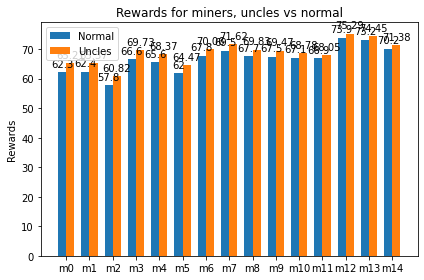

In [13]:
width = 0.35
xpos = np.arange(len(miner_names))

fig, ax = plt.subplots()
normal_plot = ax.bar(xpos - width/2, normal, width, label= "Normal")
uncles_plot = ax.bar(xpos + width/2, uncles, width, label= "Uncles")

ax.set_ylabel("Rewards")
ax.set_title("Rewards for miners, uncles vs normal")
ax.set_xticks(xpos)
ax.set_xticklabels(miner_names)
ax.legend()
ax.bar_label(normal_plot, padding=3)
ax.bar_label(uncles_plot, padding=3)
fig.tight_layout()
plt.show()

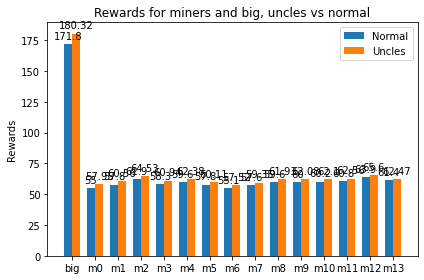

In [14]:
width = 0.35
xpos = np.arange(len(miner_names))

fig, ax = plt.subplots()
normal_plot = ax.bar(xpos - width/2, normal_big, width, label="Normal")
uncles_plot = ax.bar(xpos + width/2, uncles_big, width, label="Uncles")

ax.set_ylabel("Rewards")
ax.set_title("Rewards for miners and big, uncles vs normal")
ax.set_xticks(xpos)
ax.set_xticklabels(["big"] + miner_names[:-1])
ax.legend()
ax.bar_label(normal_plot, padding=3)
ax.bar_label(uncles_plot, padding=3)
fig.tight_layout()
plt.show()

### Testing unclerewards

To test uncle rewards we could employ many different ways of testing fairness, but we chose to do a...? Dunno what to write
-> show with code and plot what we mean. Numbers plot, whatever. Below we have run the application X times and the plot proves ... Code for uncles does not seem to work :((

### Static chain

In order to reliably test this, we decided that it was neccessary to implement a version of the blockchain without any randomness. This is achieved with the static parameter for the run method. Normally, the miners will pick randomly between block of the same height to mine on top of, but for the static chain, they will instead use their name to calculate an index (using the mod operator and sum(ord)) of their name) to select which block to mine on top of. 

Below you can see a chain that has 8 blocks in the longest, with two forks. It will always be that specific chain with the same miners on the same blocks, i.e. miner 7 will always get block 2. The chain has two forks, one of length 1 and one of length 2. We have implemented a uncle reward where a uncle who gets referenced will get a static reward, and the one referencing it will get a smaller nephew reward. In the case below, only two blocks should receive uncle rewards, the block miner 1 made that is the first in the first fork, and the block made by miner 7, in the second fork. This was easy to debug and below you can see the resulting dataframe.


In [15]:
bc, m, s = run(mining_power=40, num_blocks=8, uncle_reward=3, nephew_reward=1, static=True)
show(bc)
print(get_stats(m))

  name  reward  uncle_reward  blocks  uncles  newphes  power
0   m0      10             0       1       0        0     40
1   m1       0             3       0       1        0     40
2   m2       0             0       0       0        0     40
3   m3      10             0       1       0        0     40
4   m4      10             0       1       0        0     40
5   m5      10             0       1       0        0     40
6   m6      10             1       1       0        1     40
7   m7      20             4       2       1        1     40
8   m8       0             0       0       0        0     40
9   m9      10             0       1       0        0     40


In [16]:
bc, m, s = run(mining_power=40, num_blocks=30, uncle_reward=3, nephew_reward=1)
show(bc)

In [17]:
stats = get_stats(m, s)
print(stats)

  name  reward  uncle_reward  blocks  uncles  newphes  power
0   m0      30             4       3       1        1     40
1   m1      10             6       1       2        0     40
2   m2      50             4       5       1        1     40
3   m3       0             6       0       2        0     40
4   m4      40             7       4       2        1     40
5   m5      30             0       3       0        0     40
6   m6      30             1       3       0        1     40
7   m7      40             0       4       0        0     40
8   m8      30             1       3       0        1     40
9   m9      40             3       4       0        3     40


## Selfish mining

When a blockchain has implemented a uncle reward mechanism it eliminates some risk for the miners. When they mine a block that ends up outside the longest chain it will still be compensated somewhat for the time and energy put into the block, even if it is not on the level of the blockreward. However the blockchain may be more vulnerable to selfish mining attacks. Below you can see a model of a big miner on a uncle blockchain and a selfish miner on a uncle blockchain, where both of these have the same amount of _power_. So the difference is only how each of these miners behave. One of them will try to hide their blocks and one just publishes them. So if a uncle blockchain is more profitable to a selfish miner he should end up with more rewards than the big miner. 

In [18]:
normal_selfish, uncles_selfish, _ = getavg(100,run,num_blocks=100,num_miners=14, uncle_reward=3, nephew_reward=2, num_selfish_miners=1, mining_power_selfish=30)

In [19]:
normal_self_big, uncles_self_big, _ = getavg(100,run,num_blocks=100,num_miners=13, uncle_reward=3, nephew_reward=2,miners=[30], num_selfish_miners=1, mining_power_selfish=10)

In [ ]:
normal_self30_big, uncles_self30_big, _= getavg(100, run, num_blocks=100, num_miners=13, uncle_reward=3, nephew_reward=2,miners=[30], num_selfish_miners=1, mining_power_selfish=30)

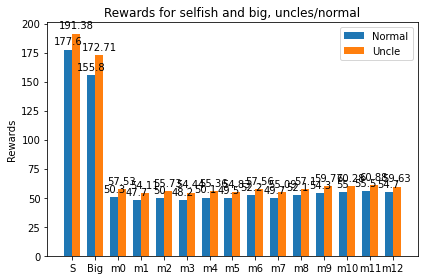

In [ ]:
width = 0.35
xpos = np.arange(len(miner_names))

fig, ax = plt.subplots()
normal_plot = ax.bar(xpos - width/2, normal_self30_big, width, label="Normal")
uncles_plot = ax.bar(xpos + width/2, uncles_self30_big, width, label="Uncle")

ax.set_ylabel("Rewards")
ax.set_title("Rewards for selfish and big, uncles/normal")
ax.set_xticks(xpos)
ax.set_xticklabels(["S", "Big"] +  miner_names[:-2])
ax.legend()
ax.bar_label(normal_plot, padding=3)
ax.bar_label(uncles_plot, padding=3)
fig.tight_layout()
plt.show()

In [ ]:
print(normal)
print(uncles)
avg = np.average(uncles)
std = np.std(uncles)
print(stats.kstest(uncles, lambda x: stats.norm.cdf(x, avg, std)))